In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
!git clone https://github.com/balajib363/ERAV2.git
!mv ERAV2/* .
!rm -rf ERAV2

!pip install torch-lr-finder
!pip install grad-cam

Cloning into 'ERAV2'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 94 (delta 21), reused 80 (delta 9), pack-reused 0
Receiving objects: 100% (94/94), 3.24 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (21/21), done.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [4]:
%cd 'session11/'
import main
import utils

from main import load_dataset, classes, train, test
from models import resnet
import torch
from torch_lr_finder import LRFinder
import torch.optim as optim
import torch.nn as nn
import copy
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

/content/session11


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:03<00:00, 44668987.55it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Load dataset and display sample images

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


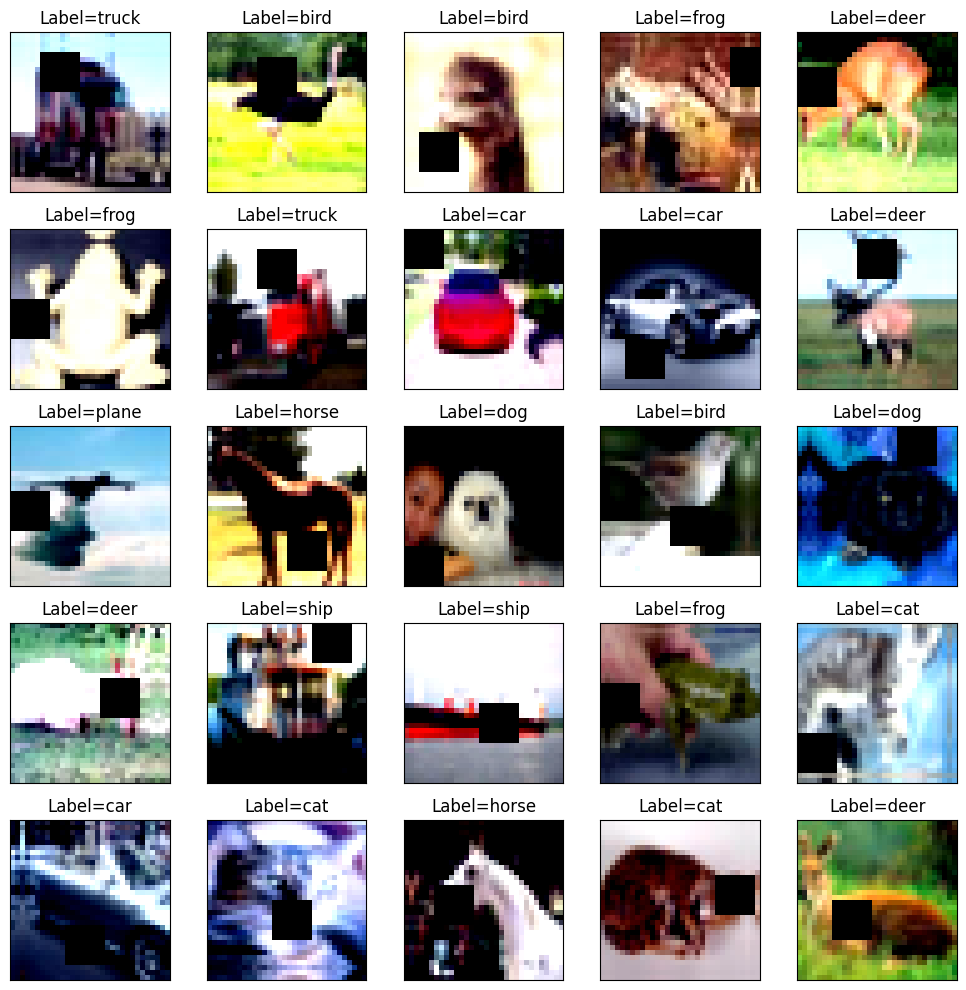

In [5]:
batch_size = 128
load_dataset_obj = load_dataset()
train_loader, test_loader = load_dataset_obj.ret_datasets(batch_size, 'cuda')
images, labels = load_dataset_obj.display_sample_imgs(train_loader, True)

# Load Resnet model and display summary

In [6]:
net = resnet.ResNet18()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Loading Resnet Model
net = net.to(device)

summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Learning rate finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.25E-03


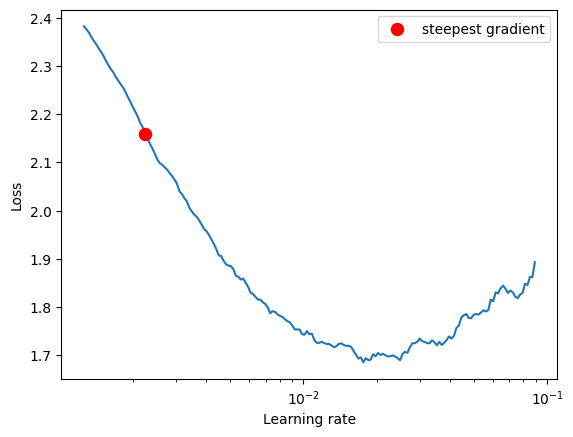

In [7]:
net_lr = copy.deepcopy(net)
optimizer = optim.SGD(net_lr.parameters(), lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_lr, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

# Set parameters for training

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=0.1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=20,
                                                pct_start=0.2,
                                                anneal_strategy='linear')

# Initialize the training

In [9]:
train = train()
test = test()
EPOCHS= 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  train.execute(net, device, train_loader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, test_loader, criterion)

Epoch: 0,Loss=1.31 Batch_id=390 Accuracy=44.52: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


Test set: Average loss: 0.0110, Accuracy: 5366/10000 (53.66%)



Epoch: 1,Loss=0.82 Batch_id=390 Accuracy=63.59: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]


Test set: Average loss: 0.0092, Accuracy: 6128/10000 (61.28%)



Epoch: 2,Loss=0.67 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Test set: Average loss: 0.0063, Accuracy: 7414/10000 (74.14%)



Epoch: 3,Loss=0.43 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


Test set: Average loss: 0.0053, Accuracy: 7761/10000 (77.61%)



Epoch: 4,Loss=0.67 Batch_id=390 Accuracy=80.59: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]


Test set: Average loss: 0.0043, Accuracy: 8132/10000 (81.32%)



Epoch: 5,Loss=0.53 Batch_id=390 Accuracy=83.03: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]


Test set: Average loss: 0.0041, Accuracy: 8272/10000 (82.72%)



Epoch: 6,Loss=0.49 Batch_id=390 Accuracy=84.76: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Test set: Average loss: 0.0042, Accuracy: 8193/10000 (81.93%)



Epoch: 7,Loss=0.44 Batch_id=390 Accuracy=86.20: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]


Test set: Average loss: 0.0037, Accuracy: 8479/10000 (84.79%)



Epoch: 8,Loss=0.48 Batch_id=390 Accuracy=87.56: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.0037, Accuracy: 8430/10000 (84.30%)



Epoch: 9,Loss=0.30 Batch_id=390 Accuracy=88.65: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Test set: Average loss: 0.0031, Accuracy: 8722/10000 (87.22%)



Epoch: 10,Loss=0.32 Batch_id=390 Accuracy=89.85: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.0028, Accuracy: 8786/10000 (87.86%)



Epoch: 11,Loss=0.32 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]


Test set: Average loss: 0.0026, Accuracy: 8890/10000 (88.90%)



Epoch: 12,Loss=0.37 Batch_id=390 Accuracy=91.33: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


Test set: Average loss: 0.0026, Accuracy: 8887/10000 (88.87%)



Epoch: 13,Loss=0.15 Batch_id=390 Accuracy=92.27: 100%|██████████| 391/391 [00:41<00:00,  9.41it/s]


Test set: Average loss: 0.0027, Accuracy: 8900/10000 (89.00%)



Epoch: 14,Loss=0.25 Batch_id=390 Accuracy=92.86: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Test set: Average loss: 0.0024, Accuracy: 9014/10000 (90.14%)



Epoch: 15,Loss=0.14 Batch_id=390 Accuracy=93.54: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]


Test set: Average loss: 0.0023, Accuracy: 9089/10000 (90.89%)



Epoch: 16,Loss=0.06 Batch_id=390 Accuracy=94.44: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Test set: Average loss: 0.0024, Accuracy: 9046/10000 (90.46%)



Epoch: 17,Loss=0.23 Batch_id=390 Accuracy=95.33: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]


Test set: Average loss: 0.0023, Accuracy: 9102/10000 (91.02%)



Epoch: 18,Loss=0.09 Batch_id=390 Accuracy=96.15: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


Test set: Average loss: 0.0022, Accuracy: 9176/10000 (91.76%)



Epoch: 19,Loss=0.04 Batch_id=390 Accuracy=97.03: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]


Test set: Average loss: 0.0021, Accuracy: 9196/10000 (91.96%)



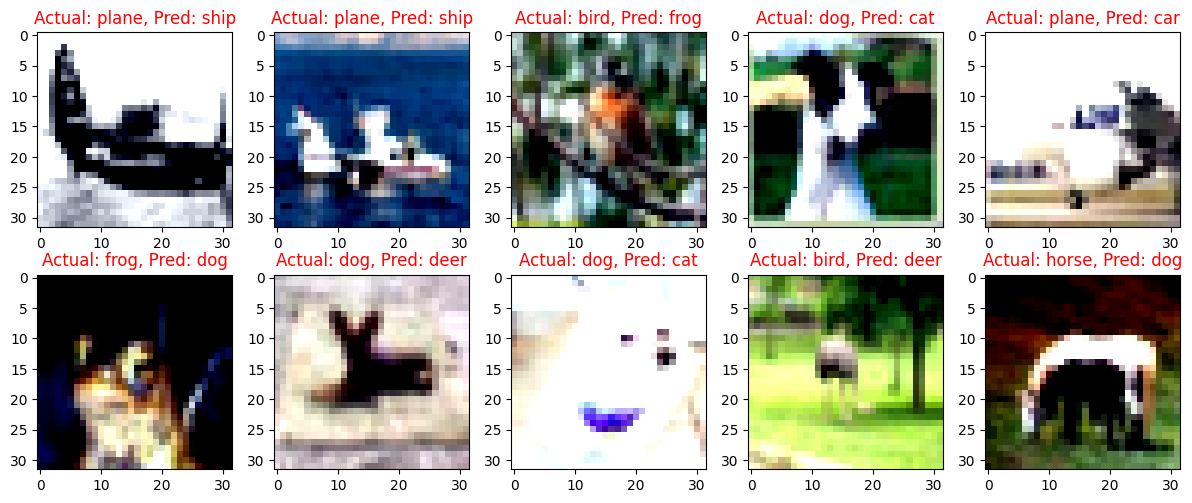

In [10]:
utils.plot_misclassified_imgs(net, test_loader, 'cuda', classes)

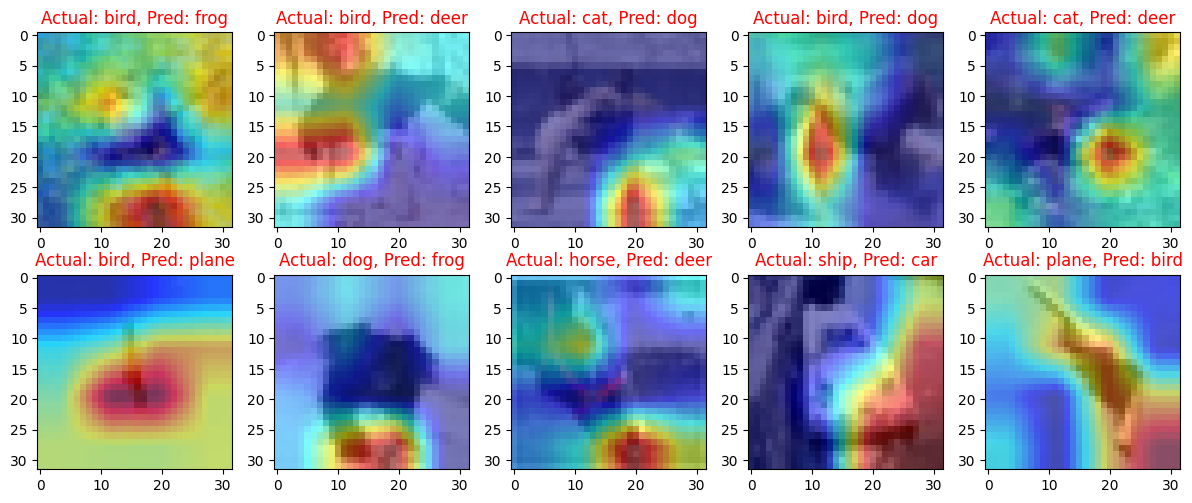

In [11]:
utils.plot_grad_cam_images(net, test_loader, classes, device)

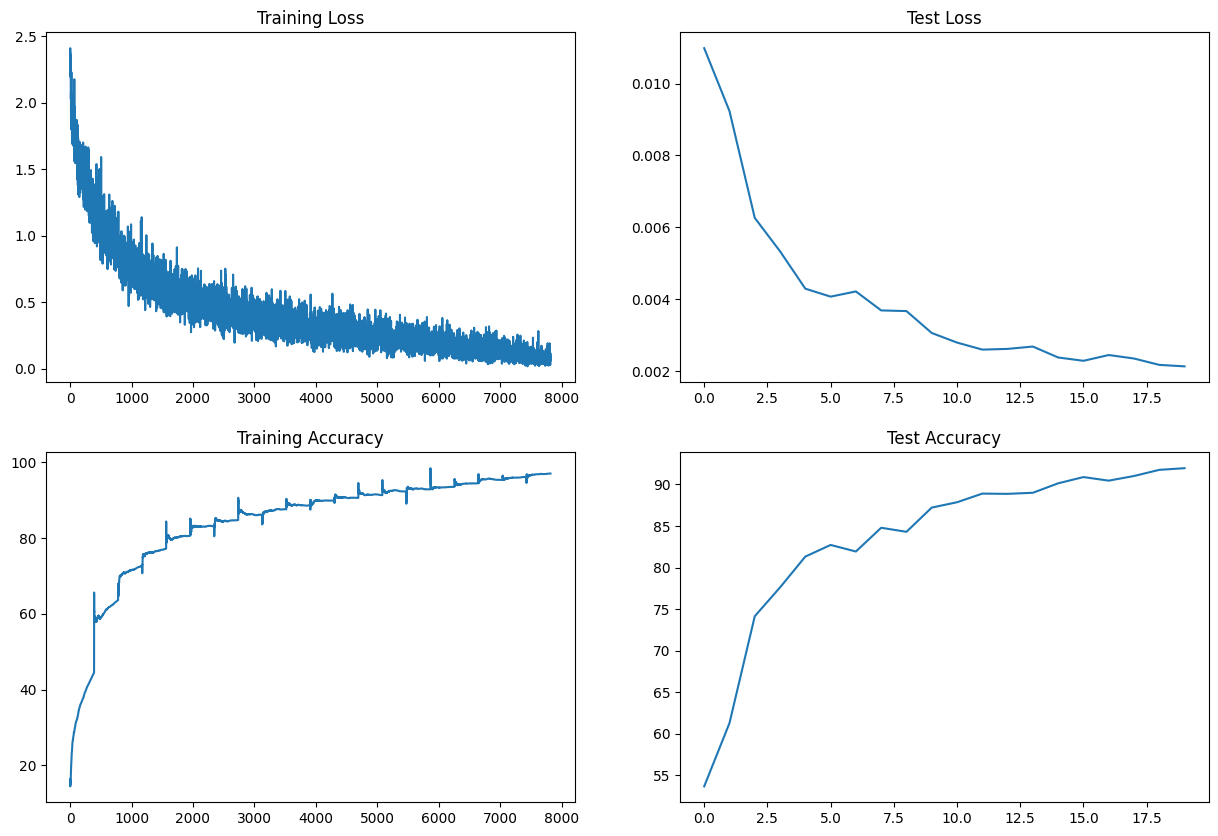

In [12]:
utils.plot_training_metrics(train, test)